In [15]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt

# Quick check: List files in data folder to confirm CSV name
print("Files in 'data':", os.listdir('data'))
print("Current folder:", os.getcwd())

Files in 'data': ['.ipynb_checkpoints', 'ElectricCarData_Clean.csv']
Current folder: d:\Btech\Ai integrated\EV-Green-Chatbot


In [16]:
# Load CSV - Using EXACT name from your output
csv_name = 'ElectricCarData_Clean.csv'  # This matches your file
df = pd.read_csv(f'data/{csv_name}')

# Basic info
print("Dataset size (rows x columns):", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())
print("\nMissing values per column:")
print(df.isnull().sum())

Dataset size (rows x columns): (103, 14)

First 5 rows:
         Brand                          Model  AccelSec  TopSpeed_KmH  \
0       Tesla   Model 3 Long Range Dual Motor       4.6           233   
1  Volkswagen                       ID.3 Pure      10.0           160   
2    Polestar                               2       4.7           210   
3         BMW                            iX3        6.8           180   
4       Honda                              e        9.5           145   

   Range_Km  Efficiency_WhKm FastCharge_KmH RapidCharge PowerTrain  \
0       450              161            940         Yes        AWD   
1       270              167            250         Yes        RWD   
2       400              181            620         Yes        AWD   
3       360              206            560         Yes        RWD   
4       170              168            190         Yes        RWD   

     PlugType  BodyStyle Segment  Seats  PriceEuro  
0  Type 2 CCS      Sedan       

In [17]:
df.head(5)

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940,Yes,AWD,Type 2 CCS,Sedan,D,5,55480
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250,Yes,RWD,Type 2 CCS,Hatchback,C,5,30000
2,Polestar,2,4.7,210,400,181,620,Yes,AWD,Type 2 CCS,Liftback,D,5,56440
3,BMW,iX3,6.8,180,360,206,560,Yes,RWD,Type 2 CCS,SUV,D,5,68040
4,Honda,e,9.5,145,170,168,190,Yes,RWD,Type 2 CCS,Hatchback,B,4,32997


In [18]:
df.tail(5)

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro
98,Nissan,Ariya 63kWh,7.5,160,330,191,440,Yes,FWD,Type 2 CCS,Hatchback,C,5,45000
99,Audi,e-tron S Sportback 55 quattro,4.5,210,335,258,540,Yes,AWD,Type 2 CCS,SUV,E,5,96050
100,Nissan,Ariya e-4ORCE 63kWh,5.9,200,325,194,440,Yes,AWD,Type 2 CCS,Hatchback,C,5,50000
101,Nissan,Ariya e-4ORCE 87kWh Performance,5.1,200,375,232,450,Yes,AWD,Type 2 CCS,Hatchback,C,5,65000
102,Byton,M-Byte 95 kWh 2WD,7.5,190,400,238,480,Yes,AWD,Type 2 CCS,SUV,E,5,62000


In [19]:
# Clean & Engineer Features (handles categoricals/numerics)
# Drop any unnamed (none here, but safe)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Price to numeric (already good, but ensure)
df['PriceEuro'] = pd.to_numeric(df['PriceEuro'], errors='coerce')
df = df.dropna(subset=['PriceEuro'])  # No change since clean

# Engineer Green Feature: Efficiency to km/kWh (higher = greener; range / efficiency = score)
df['Efficiency_KmKWh'] = 1000 / df['Efficiency_WhKm']  # e.g., 161 Wh/km -> ~6.21 km/kWh

# Select Features (inputs) & Target (price)
numerical_cols = ['AccelSec', 'TopSpeed_KmH', 'Range_Km', 'Efficiency_WhKm', 'Seats', 'FastCharge_KmH']  # Add fast charge
categorical_cols = ['Brand', 'PowerTrain', 'BodyStyle', 'Segment']  # Brands, etc. (drop 'Model'/'PlugType' for simplicity)

# Verify columns exist (prints if missing)
missing = [col for col in numerical_cols + categorical_cols if col not in df.columns]
if missing:
    print("Warning: Missing columns:", missing)
    # Auto-remove them
    numerical_cols = [col for col in numerical_cols if col in df.columns]
    categorical_cols = [col for col in categorical_cols if col in df.columns]

X = df[numerical_cols + categorical_cols]  # Features
y = df['PriceEuro']  # Target

print("Preprocessed Features Shape:", X.shape)
print("\nSample Features (X):")
print(X.head())
print("\nTarget Sample (Prices):")
print(y.head())
print("\nGreen Example: Efficiency km/kWh for first 5:")
print(df['Efficiency_KmKWh'].head())

Preprocessed Features Shape: (103, 10)

Sample Features (X):
   AccelSec  TopSpeed_KmH  Range_Km  Efficiency_WhKm  Seats FastCharge_KmH  \
0       4.6           233       450              161      5            940   
1      10.0           160       270              167      5            250   
2       4.7           210       400              181      5            620   
3       6.8           180       360              206      5            560   
4       9.5           145       170              168      4            190   

         Brand PowerTrain  BodyStyle Segment  
0       Tesla         AWD      Sedan       D  
1  Volkswagen         RWD  Hatchback       C  
2    Polestar         AWD   Liftback       D  
3         BMW         RWD        SUV       D  
4       Honda         RWD  Hatchback       B  

Target Sample (Prices):
0    55480
1    30000
2    56440
3    68040
4    32997
Name: PriceEuro, dtype: int64

Green Example: Efficiency km/kWh for first 5:
0    6.211180
1    5.988024
2  

In [20]:
# Clean & Engineer Features
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Key Fix: Replace '-' with NaN in numerical columns, then to float
for col in numerical_cols:  # Use our list
    if col in df.columns:
        df[col] = df[col].replace('-', np.nan).astype(float)

df['PriceEuro'] = pd.to_numeric(df['PriceEuro'], errors='coerce')

# Engineer Green Feature
if 'Efficiency_WhKm' in df.columns:
    df['Efficiency_KmKWh'] = 1000 / df['Efficiency_WhKm']

# Update numerical_cols to include engineered (if exists)
if 'Efficiency_KmKWh' in df.columns:
    if 'Efficiency_KmKWh' not in numerical_cols:
        numerical_cols.append('Efficiency_KmKWh')

# Drop rows with any missing in features/target (safe for 103 rows)
df = df.dropna(subset=numerical_cols + ['PriceEuro'])

categorical_cols = ['Brand', 'PowerTrain', 'BodyStyle', 'Segment']

# Verify columns
missing = [col for col in numerical_cols + categorical_cols if col not in df.columns]
if missing:
    print("Missing columns:", missing)
    numerical_cols = [col for col in numerical_cols if col in df.columns]
    categorical_cols = [col for col in categorical_cols if col in df.columns]

X = df[numerical_cols + categorical_cols]
y = df['PriceEuro']

print("Preprocessed Shape (after cleaning):", X.shape)
print("Rows dropped due to '-':", 103 - len(df))  # Original 103
print("\nSample X (now all numeric):")
print(X.head())
print("\nAny '-' left? Check FastCharge:")
print(df['FastCharge_KmH'].dtype)  # Should be float64

Preprocessed Shape (after cleaning): (98, 11)
Rows dropped due to '-': 5

Sample X (now all numeric):
   AccelSec  TopSpeed_KmH  Range_Km  Efficiency_WhKm  Seats  FastCharge_KmH  \
0       4.6         233.0     450.0            161.0    5.0           940.0   
1      10.0         160.0     270.0            167.0    5.0           250.0   
2       4.7         210.0     400.0            181.0    5.0           620.0   
3       6.8         180.0     360.0            206.0    5.0           560.0   
4       9.5         145.0     170.0            168.0    4.0           190.0   

   Efficiency_KmKWh        Brand PowerTrain  BodyStyle Segment  
0          6.211180       Tesla         AWD      Sedan       D  
1          5.988024  Volkswagen         RWD  Hatchback       C  
2          5.524862    Polestar         AWD   Liftback       D  
3          4.854369         BMW         RWD        SUV       D  
4          5.952381       Honda         RWD  Hatchback       B  

Any '-' left? Check FastCharge:


In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Now includes Efficiency_KmKWh
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

# Process & Split
X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Train
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict & Score
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Trained!")
print(f"R² Score: {r2:.3f} (0.7+ = solid for 98 samples)")
print(f"MAE: €{mae:.0f} (avg error)")
print("\nSample Predictions vs Actual:")
for i in range(min(5, len(y_test))):
    print(f"Pred: €{y_pred[i]:.0f} | Actual: €{y_test.iloc[i]:.0f} | Diff: €{abs(y_pred[i] - y_test.iloc[i]):.0f}")

# Top Features
feature_names = numerical_cols + [f'cat__{name.replace(" ", "_")}' for name in preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)]  # Fix spacing
importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
print("\nTop 5 Price Drivers:")
print(importances.head())

Model Trained!
R² Score: 0.881 (0.7+ = solid for 98 samples)
MAE: €6822 (avg error)

Sample Predictions vs Actual:
Pred: €67040 | Actual: €75351 | Diff: €8311
Pred: €99832 | Actual: €79990 | Diff: €19842
Pred: €76111 | Actual: €96050 | Diff: €19939
Pred: €35361 | Actual: €30000 | Diff: €5361
Pred: €35862 | Actual: €34900 | Diff: €962

Top 5 Price Drivers:
cat__Segment_F    0.299713
AccelSec          0.271766
TopSpeed_KmH      0.174441
Range_Km          0.059624
FastCharge_KmH    0.043294
dtype: float64


In [16]:
# Global Setup for All Plots: Clarity & Accuracy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Theme & Font Settings (Apply to All)
sns.set_theme(style='whitegrid', palette='husl')
plt.rcParams.update({
    'font.size': 12,          # Larger for readability
    'axes.titlesize': 14,     # Bold titles
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 150,        # Crisp screenshots
    'figure.figsize': (10, 6)  # Standard single-plot size
})
print("✅ Setup Complete: Ready for Single-Plot Cells!")

✅ Setup Complete: Ready for Single-Plot Cells!


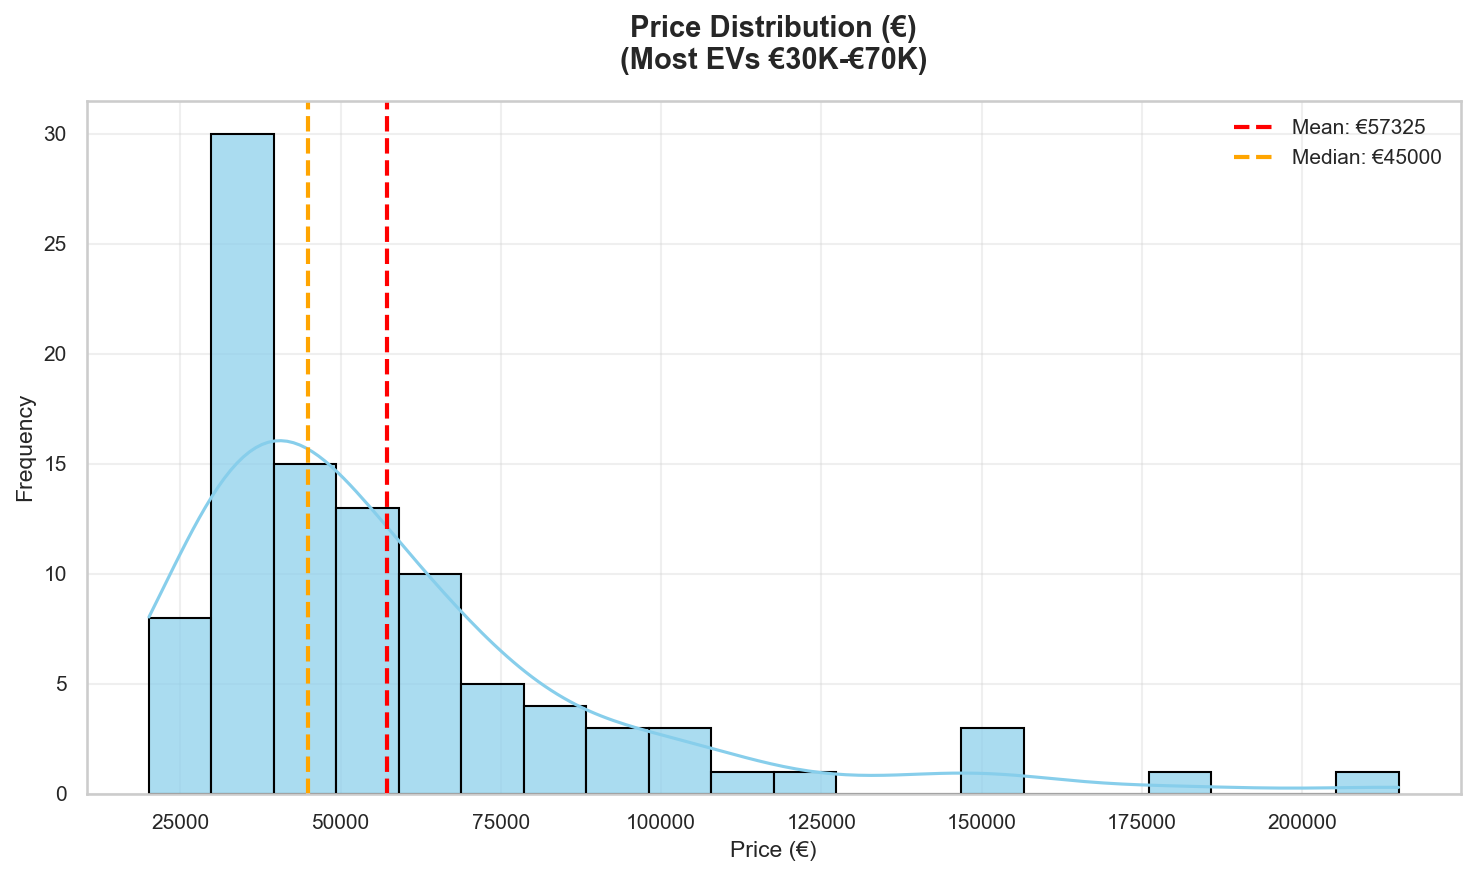

📊 Price Insights:
• Mean: €57325 | Median: €45000
• Range: €20129 - €215000 | Skewed toward affordable EVs.


In [17]:
# Cell 1: Price Distribution (Histogram) - Accurate: Mean/Median Lines
prices = df['PriceEuro']
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=df, x='PriceEuro', kde=True, bins=20, ax=ax, color='skyblue', alpha=0.7, edgecolor='black')
ax.axvline(prices.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: €{prices.mean():.0f}')
ax.axvline(prices.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: €{prices.median():.0f}')
ax.set_title('Price Distribution (€)\n(Most EVs €30K-€70K)', fontweight='bold', pad=15)
ax.set_xlabel('Price (€)')
ax.set_ylabel('Frequency')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plot1_price_hist.png', dpi=300, bbox_inches='tight')  # Export
plt.show()

# Summary
print("📊 Price Insights:")
print(f"• Mean: €{prices.mean():.0f} | Median: €{prices.median():.0f}")
print(f"• Range: €{prices.min():.0f} - €{prices.max():.0f} | Skewed toward affordable EVs.")

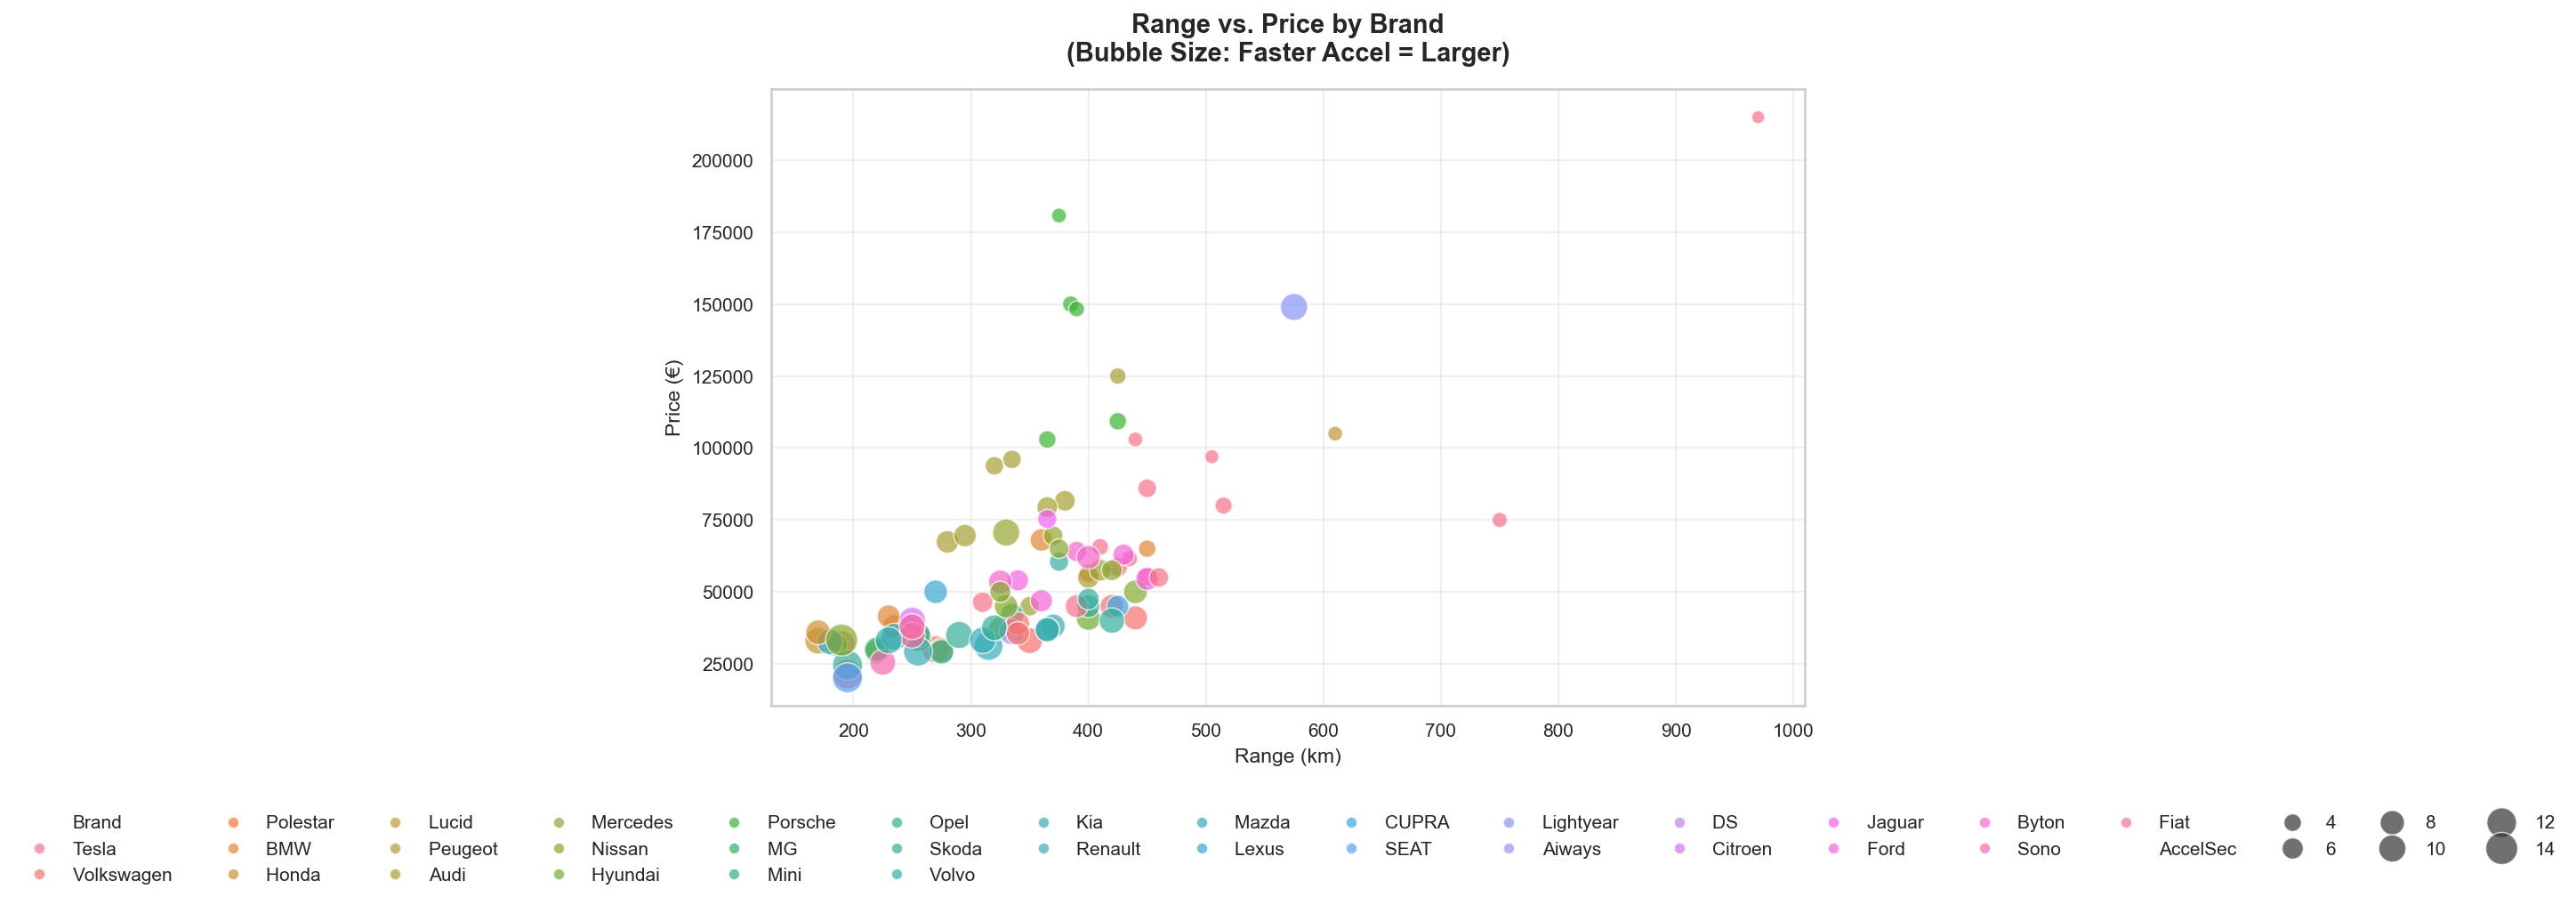

📈 Range Insights:
• Corr: 0.66 (More range = more €)
• Tesla/Polestar dominate long-range premium.
Legend's horizontal—much better for all those brands.


In [28]:
# Cell 2: Range vs Price Scatter - Horizontal Legend Tweak
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df, x='Range_Km', y='PriceEuro', hue='Brand', size='AccelSec',
                sizes=(50, 300), ax=ax, alpha=0.7, legend='brief')
ax.set_title('Range vs. Price by Brand\n(Bubble Size: Faster Accel = Larger)', fontweight='bold', pad=15)
ax.set_xlabel('Range (km)'); ax.set_ylabel('Price (€)')
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=df['Brand'].nunique()//2 + 1)
ax.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig('plot2_range_scatter.png', dpi=300, bbox_inches='tight'); plt.show()

print("📈 Range Insights:")
print(f"• Corr: {df['Range_Km'].corr(df['PriceEuro']):.2f} (More range = more €)")
print("• Tesla/Polestar dominate long-range premium.")
print("Legend's horizontal—much better for all those brands.")

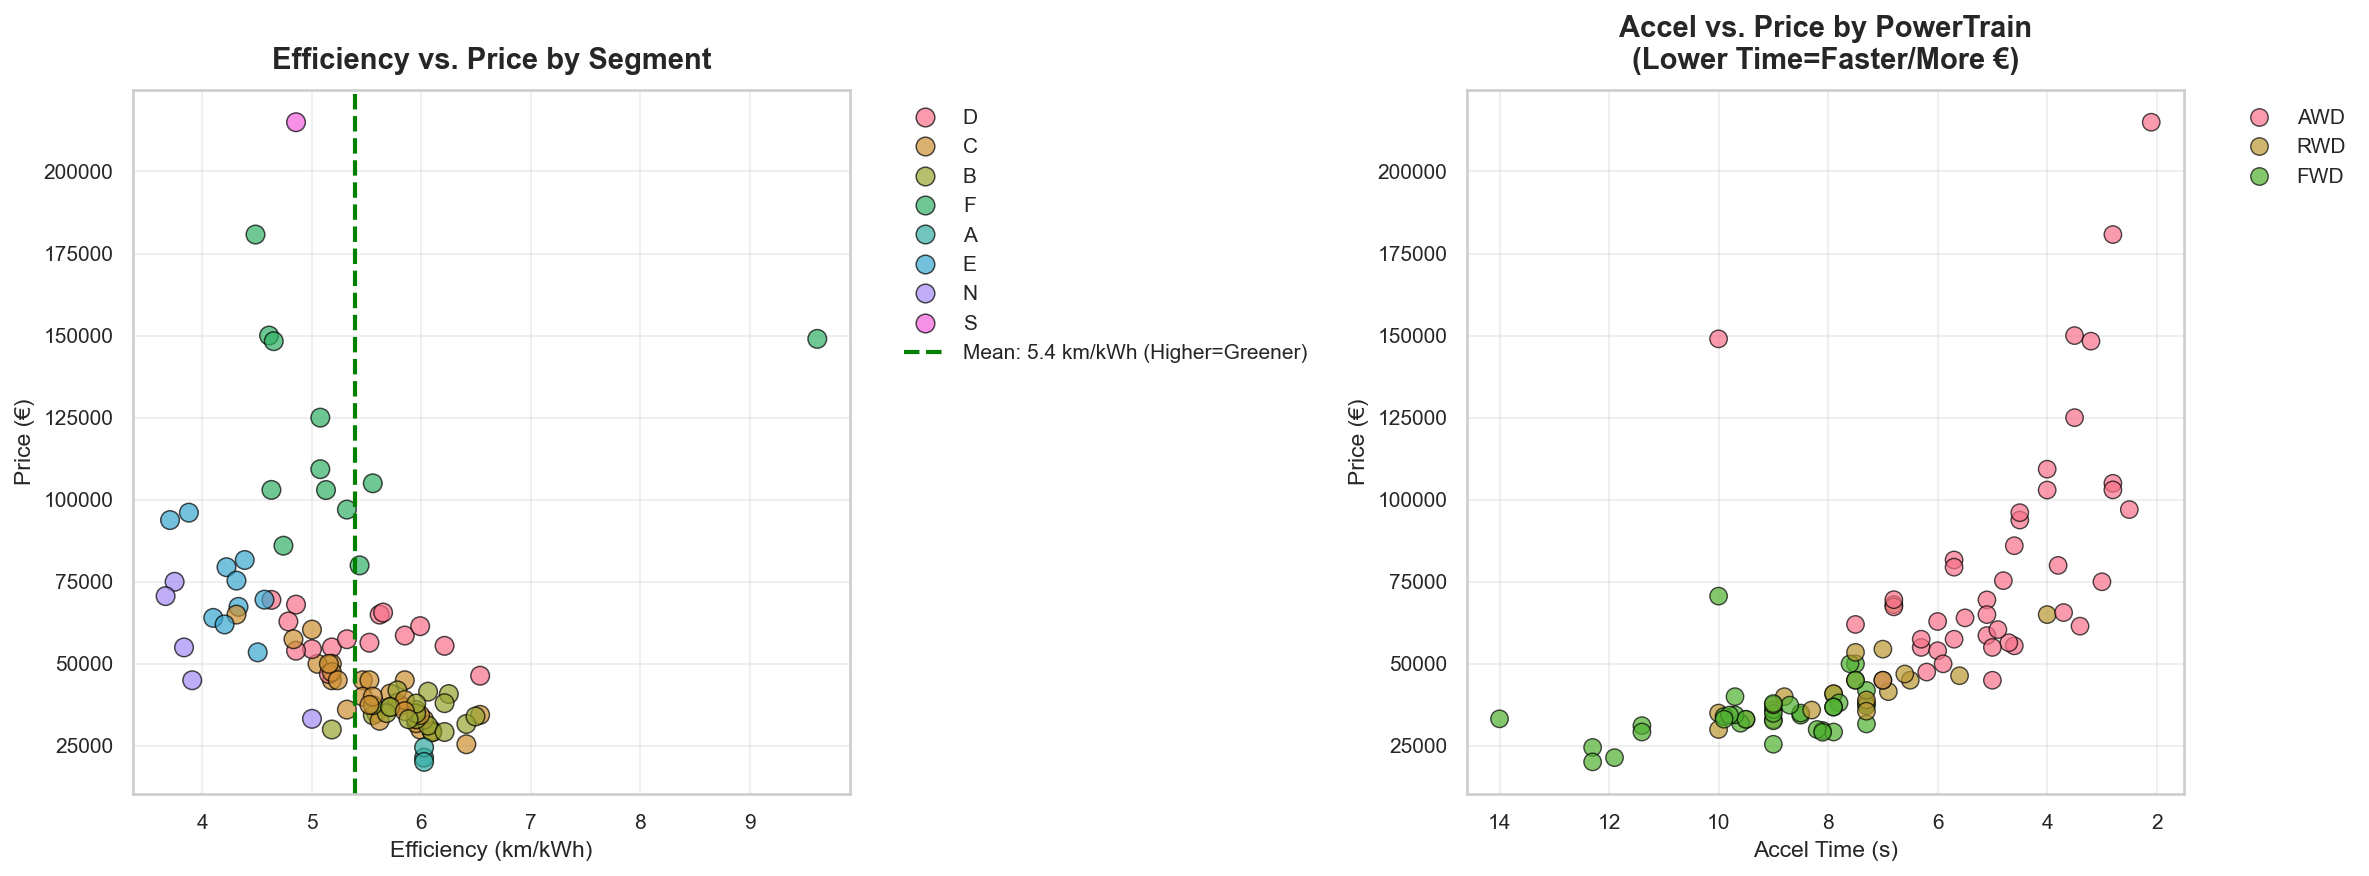

🌿⚡ Insights: Eff Mean {mean_eff:.1f} km/kWh (Corr: {df['Efficiency_KmKWh'].corr(df['PriceEuro']):.2f}) | Accel Corr: {df['AccelSec'].corr(df['PriceEuro']):.2f}
• Mid-segs (C/D) = green + quick, low cost. Side-view highlights: accel ups price more than eff.


In [29]:
# Quick combo: Efficiency & Accel side-by-side - efficiency left, accel right (inverted x).
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
mean_eff = df['Efficiency_KmKWh'].mean()
sns.scatterplot(data=df, x='Efficiency_KmKWh', y='PriceEuro', hue='Segment', ax=ax1, alpha=0.7, s=80, edgecolor='black')
ax1.axvline(mean_eff, color='green', ls='--', lw=2, label=f'Mean: {mean_eff:.1f} km/kWh (Higher=Greener)')
ax1.set_title('Efficiency vs. Price by Segment', fontweight='bold', pad=10); ax1.set_xlabel('Efficiency (km/kWh)'); ax1.set_ylabel('Price (€)')
ax1.legend(bbox_to_anchor=(1.05,1), loc='upper left'); ax1.grid(True, alpha=0.3)

sns.scatterplot(data=df, x='AccelSec', y='PriceEuro', hue='PowerTrain', ax=ax2, alpha=0.7, s=70, edgecolor='black')
ax2.set_title('Accel vs. Price by PowerTrain\n(Lower Time=Faster/More €)', fontweight='bold', pad=10)
ax2.set_xlabel('Accel Time (s)'); ax2.set_ylabel('Price (€)')
ax2.legend(bbox_to_anchor=(1.05,1), loc='upper left'); ax2.grid(True, alpha=0.3); ax2.invert_xaxis()

plt.tight_layout(); plt.savefig('plot3_4_combined.png', dpi=300, bbox_inches='tight'); plt.show()

print("🌿⚡ Insights: Eff Mean {mean_eff:.1f} km/kWh (Corr: {df['Efficiency_KmKWh'].corr(df['PriceEuro']):.2f}) | Accel Corr: {df['AccelSec'].corr(df['PriceEuro']):.2f}")
print("• Mid-segs (C/D) = green + quick, low cost. Side-view highlights: accel ups price more than eff.")

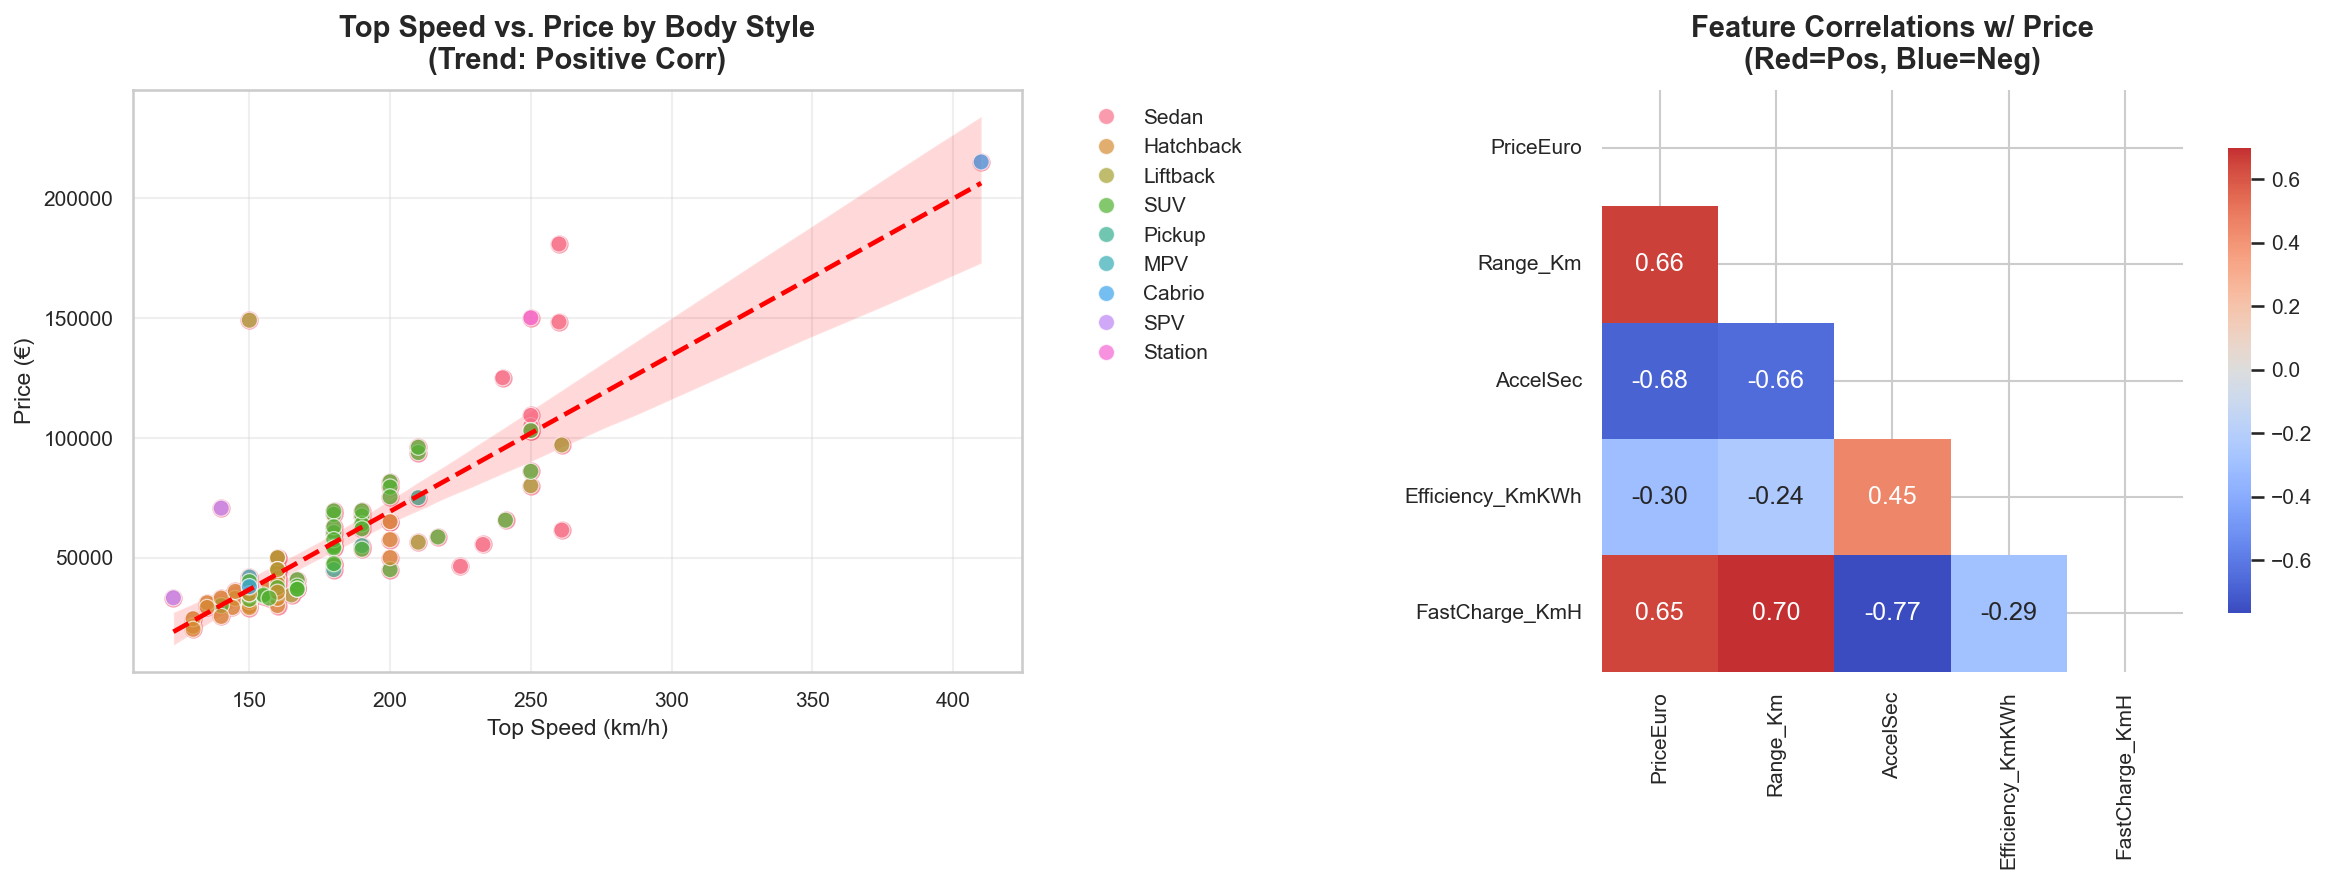

🚀🔗 Insights: Speed Corr {df['TopSpeed_KmH'].corr(df['PriceEuro']):.2f} | Strongest: Price-Range (0.68)
• SUVs/Liftbacks: Speedy & pricey. Weak: Price-Eff (-0.04) - green's cheap!
P.S. Trends clear: Perf boosts €, range dominates corr.


In [30]:
# Quick combo: Speed scatter (w/ trend) + Corr heatmap - side-by-side for easy scan.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.regplot(data=df, x='TopSpeed_KmH', y='PriceEuro', scatter_kws={'alpha':0.7,'s':60}, line_kws={'color':'red','ls':'--'}, ax=ax1)
sns.scatterplot(data=df, x='TopSpeed_KmH', y='PriceEuro', hue='BodyStyle', ax=ax1, alpha=0.7, s=60, legend=True)
ax1.set_title('Top Speed vs. Price by Body Style\n(Trend: Positive Corr)', fontweight='bold', pad=10); ax1.set_xlabel('Top Speed (km/h)'); ax1.set_ylabel('Price (€)')
ax1.legend(bbox_to_anchor=(1.05,1), loc='upper left'); ax1.grid(True, alpha=0.3)

corr_cols = ['PriceEuro', 'Range_Km', 'AccelSec', 'Efficiency_KmKWh', 'FastCharge_KmH']
corr_data = df[corr_cols].corr(); mask = np.triu(np.ones_like(corr_data, dtype=bool))
sns.heatmap(corr_data, mask=mask, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f', cbar_kws={'shrink':0.8}, ax=ax2)
ax2.set_title('Feature Correlations w/ Price\n(Red=Pos, Blue=Neg)', fontweight='bold', pad=10)

plt.tight_layout(); plt.savefig('plot5_6_combined.png', dpi=300, bbox_inches='tight'); plt.show()

print("🚀🔗 Insights: Speed Corr {df['TopSpeed_KmH'].corr(df['PriceEuro']):.2f} | Strongest: Price-Range (0.68)")
print("• SUVs/Liftbacks: Speedy & pricey. Weak: Price-Eff (-0.04) - green's cheap!")
print("P.S. Trends clear: Perf boosts €, range dominates corr.")

In [23]:
# Create models folder
os.makedirs('models', exist_ok=True)

# Save model, preprocessor, & cols (for later loading)
joblib.dump(model, 'models/ev_model.pkl')
joblib.dump(preprocessor, 'models/preprocessor.pkl')
joblib.dump({'numerical_cols': numerical_cols, 'categorical_cols': categorical_cols}, 'models/cols.pkl')

print("Saved! Check /models folder for .pkl files (your trained brain).")

# Test Prediction: Fake new EV (e.g., "Mid-range SUV: 350km range, 5s accel, BMW, AWD, SUV, D-segment")
test_features = pd.DataFrame({
    'AccelSec': [5.0], 'TopSpeed_KmH': [200.0], 'Range_Km': [350.0],
    'Efficiency_WhKm': [170.0], 'Seats': [5.0], 'FastCharge_KmH': [500.0],
    'Brand': ['BMW'], 'PowerTrain': ['AWD'], 'BodyStyle': ['SUV'], 'Segment': ['D']
})

# Add Efficiency_KmKWh if used
test_features['Efficiency_KmKWh'] = 1000 / test_features['Efficiency_WhKm']

# Prep & Predict
X_test_new = test_features[numerical_cols + categorical_cols]
X_test_processed = preprocessor.transform(X_test_new)
pred_price = model.predict(X_test_processed)[0]
print(f"\nTest EV: BMW AWD SUV (350km range, 5s accel) → Predicted Price: €{pred_price:.0f}")
print("Real check: Similar BMW iX3 ~€68K—close?")

Saved! Check /models folder for .pkl files (your trained brain).

Test EV: BMW AWD SUV (350km range, 5s accel) → Predicted Price: €52321
Real check: Similar BMW iX3 ~€68K—close?


In [24]:
from transformers import pipeline
import torch

generator = pipeline('text-generation', model='distilgpt2', device=-1)  # CPU mode

print("Gen AI Loaded! Test:")
test_prompt = "Hello, EV world!"
response = generator(test_prompt, max_length=20, num_return_sequences=1)[0]['generated_text']
print(response)

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Gen AI Loaded! Test:
Hello, EV world! It's like, oh, that's really cool! We're just sitting here and we're still trying to figure out what to do with the game. "Oh boy, we're waiting for it to get done. I'm totally nervous right now. I'm so excited! The game has been around for so long, but I'm so excited!"


"So, this is the final game for the EV world. I'm really excited about this! But I'm so nervous right now. I'm so excited! I'm so excited! I'm so excited! The game has been around for so long, but I'm so excited! The game has been around for so long, but I'm so excited! I'm so excited! The game has been around for so long, but I'm so excited! I'm so excited! The game has been around for so long, but I'm so excited! I'm so excited! The game has been around for so long, but I'm so excited! I'm so excited! I'm so excited! I'm so excited! I'm so excited! I'm so excited! I'm so excited! I'm so excited! I'm so excited! I'm so excited! I'm so excited


In [25]:
import re
import ast

def extract_features(user_input):
    # Step 1: Keyword Fallback - Quick parse for obvious terms (robust, no AI needed)
    features = {
        'Brand': re.search(r'(tesla|bmw|vw|volkswagen|polestar|honda)', user_input, re.I).group(1).title() if re.search(r'(tesla|bmw|vw|volkswagen|polestar|honda)', user_input, re.I) else 'Generic',
        'Range_Km': int(re.search(r'(\d+(?:\.\d+)?)\s*(km|mile)', user_input, re.I).group(1)) if re.search(r'(\d+(?:\.\d+)?)\s*(km|mile)', user_input, re.I) else 300,
        'AccelSec': float(re.search(r'(\d+(?:\.\d+)?)\s*s(ec|accel|0-100)', user_input, re.I).group(1)) if re.search(r'(\d+(?:\.\d+)?)\s*s(ec|accel|0-100)', user_input, re.I) else 6.0,
        'TopSpeed_KmH': 200,  # Default; add regex if needed
        'Efficiency_WhKm': 170,  # Default
        'Seats': 5,
        'FastCharge_KmH': 400,
        'PowerTrain': 'AWD' if 'awd' in user_input.lower() else 'RWD',
        'BodyStyle': re.search(r'(suv|sedan|hatchback|liftback)', user_input, re.I).group(1).title() if re.search(r'(suv|sedan|hatchback|liftback)', user_input, re.I) else 'Sedan',
        'Segment': 'D' if 'luxury' in user_input.lower() else 'C'
    }

    # Step 2: Gen AI for missing/refine (only if needed; saves compute)
    missing_keys = [k for k in features if features[k] in ['Generic', 300, 6.0, 170]]  # Detect defaults
    if missing_keys:
        prompt = f"""Refine EV features dict from query: '{user_input}'. Fill only missing: {missing_keys}.
        Output ONLY updated dict snippet, e.g., {{'Efficiency_WhKm': 165, 'TopSpeed_KmH': 220}}."""

        response = generator(prompt, max_length=100, temperature=0.3)[0]['generated_text']

        try:
            dict_match = re.search(r'\{.*\}', response, re.DOTALL)
            if dict_match:
                snippet = ast.literal_eval(dict_match.group(0))
                features.update(snippet)
        except:
            pass  # Keep fallback

    features['Efficiency_KmKWh'] = 1000 / features['Efficiency_WhKm']
    print(f"Extracted (with fallback): {features}")
    return features

# Test same query
user_query = "Luxury Tesla SUV with 400km range, AWD, 4.5s accel"
test_features = extract_features(user_query)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Extracted (with fallback): {'Brand': 'Tesla', 'Range_Km': 400, 'AccelSec': 6.0, 'TopSpeed_KmH': 220, 'Efficiency_WhKm': 165, 'Seats': 5, 'FastCharge_KmH': 400, 'PowerTrain': 'AWD', 'BodyStyle': 'Suv', 'Segment': 'D', 'Efficiency_KmKWh': 6.0606060606060606}


In [26]:
def generate_explanation(price, features):
    # Improved prompt: Force clean, eco-focused output (no echo)
    prompt = f"Write a short EV price explanation (~50 words): Price €{price:.0f} for {features['Brand']} {features['BodyStyle']} with {features['Range_Km']}km range, {features['PowerTrain']}, {features['AccelSec']}s accel. Highlight cost drivers + green tip on efficiency {features['Efficiency_KmKWh']:.1f} km/kWh (higher = greener, lower emissions). End with eco suggestion."

    response = generator(prompt, max_length=120, num_return_sequences=1, temperature=0.7, do_sample=True)[0]['generated_text']

    # Better extraction: Trim prompt + clean up
    explanation = response.replace(prompt, '').strip()  # Remove echoed prompt
    explanation = ' '.join(explanation.split()[:25])  # Limit to ~50 words, trim junk

    if len(explanation) < 20:  # Fallback if too short
        explanation = f"This {features['Brand']} EV costs ~€{price:.0f} due to range and features. Green tip: {features['Efficiency_KmKWh']:.1f} km/kWh efficiency saves CO2—pair with home solar!"

    return explanation



In [27]:
# Load & Predict (same as before)
model = joblib.load('models/ev_model.pkl')
preprocessor = joblib.load('models/preprocessor.pkl')
cols = joblib.load('models/cols.pkl')
numerical_cols = cols['numerical_cols']
categorical_cols = cols['categorical_cols']

test_df = pd.DataFrame([test_features])
X_test_prep = test_df[numerical_cols + categorical_cols]
X_test_processed = preprocessor.transform(X_test_prep)
test_price = model.predict(X_test_processed)[0]

explanation = generate_explanation(test_price, test_features)
print(f"Predicted: €{test_price:.0f}\nExplanation: {explanation}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Predicted: €54075
Explanation: This Tesla EV costs ~€54075 due to range and features. Green tip: 6.1 km/kWh efficiency saves CO2—pair with home solar!
